<a href="https://colab.research.google.com/github/jeslinpjames/ML_Algorithms_ParallelComputing/blob/main/Supermarket_Customer_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [ ]:
# Load the dataset (Update the path if necessary)
df = pd.read_csv('/content/supermarket_sales - Sheet1.csv')

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Drop unnecessary columns (Invoice ID, Date, Time, as they don't contribute to clustering)
df.drop(['Invoice ID', 'Date', 'Time'], axis=1, inplace=True)

# Convert categorical columns into numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment'], drop_first=True)

# Select relevant numerical features for clustering
features = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross margin percentage', 'gross income', 'Rating']
df_features = df_encoded[features]

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)


    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  
0  13:08      Ewallet  522.83                 4.761905       26.1415     9.1  
1  10:

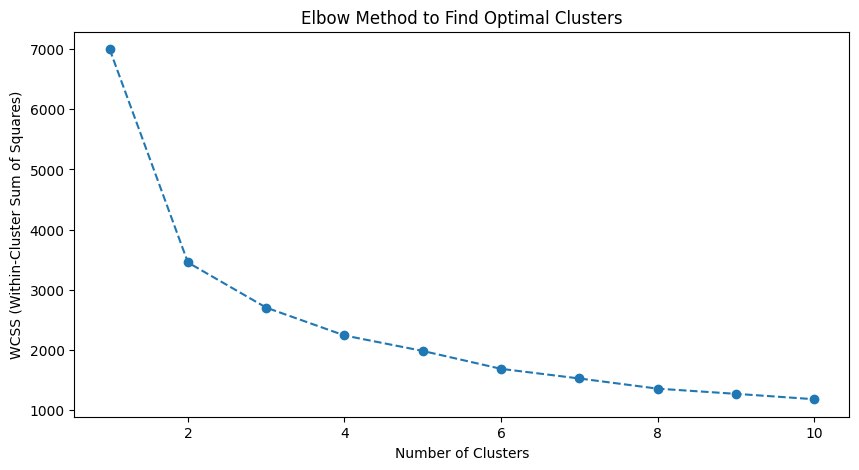

In [ ]:
# Compute Within-Cluster Sum of Squares (WCSS) for different cluster counts
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method to Find Optimal Clusters')
plt.show()


In [ ]:
# Choosing an optimal number of clusters (e.g., k=4 from elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(df_scaled)

# Compute silhouette score to validate clustering quality
silhouette_avg = silhouette_score(df_scaled, df_encoded['Cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.4f}")


Silhouette Score for k=4: 0.2748


In [ ]:
# Ensure only numeric columns are used for aggregation
df_numeric = df_encoded.select_dtypes(include=[np.number])
df_numeric['Cluster'] = df_encoded['Cluster']

# Group by cluster and compute the mean for numerical features
cluster_analysis = df_numeric.groupby('Cluster').mean()

# Display the analysis
print(cluster_analysis)


         Unit price  Quantity     Tax 5%       Total        cogs  \
Cluster                                                            
0         68.198773  6.256506  20.012039  420.252820  400.240781   
1         83.929162  8.724551  36.263398  761.531362  725.267964   
2         26.666178  7.124444   9.285991  195.005813  185.719822   
3         51.063717  2.262537   5.459572  114.651018  109.191445   

         gross margin percentage  gross income    Rating  
Cluster                                                   
0                       4.761905     20.012039  7.060223  
1                       4.761905     36.263398  6.629341  
2                       4.761905      9.285991  7.112889  
3                       4.761905      5.459572  6.979351  


In [ ]:
# Reduce dataset to 3 components for 3D visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

# Create a new dataframe with PCA components
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['Cluster'] = df_encoded['Cluster'].values
df_pca['Rating'] = df['Rating'].values  # Retain rating for better visualization


In [ ]:
# 3D Scatter Plot using Plotly
fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='Rating', color=df_pca['Cluster'].astype(str),
                    title='3D Scatter Plot of Customer Segments',
                    labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2', 'Rating': 'Customer Rating'},
                    opacity=0.7)

fig.update_traces(marker=dict(size=5))
fig.show()
